In [1]:
import RNA
# Code folding for jupyter
import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')

# RNA.cvar.fold_constrained = 0
# structure = ""
# print RNA.pf_fold("AAGGGAAACCCA", structure)
# # RNA.get_subseq_F(4,11)
# f5_p,c_p,fML_p,fM1_p,indx_p,ptype_p = [""]*6
# RNA.export_fold_arrays(f5_p,c_p,fML_p,fM1_p,indx_p,ptype_p)
# # RNA.alloc_sequence_arrays
# from RNA import fold_compound

# comp = RNA.fold_compound
# RNA.export_fold_arrays
# getBPPM("AACGGGAAAGCCA")



In [2]:
%matplotlib inline
E.enable_nbextension('usability/codefolding/main')

import RNA
import numpy as np 
from altschulEriksonDinuclShuffle import dinuclShuffle
import random
# def get_subsequence_prob(rna_seq):

def my_eval(rna_seq, context, l_pos, r_pos, rna_split_pos, step=10):
    context = context.upper()
    cont_lengths, inner_probs, outer_probs = [] , [], []
    for context_len in range(0,600,step):
        # select a range of the context, each time reshuffle to not stick into a (rare) sub-minimal case
        selection = dinuclShuffle(context)[0:context_len]
        # Insert the rna inbetween selection, insert position is from a normal distribution with mean 
        # be the center of the selected context
        center_pos = len(selection)/2
        insert_pos = max(0, int(np.random.normal(center_pos, 1+center_pos*0.1 )))
        print "(", context_len, center_pos, insert_pos, ")", 
        full_seq_inner = selection[:insert_pos] +  rna_seq + selection[insert_pos:]
        full_seq_outer = rna_seq[:rna_split_pos] +  selection + rna_seq[rna_split_pos:]
        print full_seq_outer
    #     print full_seq[insert_pos:insert_pos+len(histone)]
    #     print full_seq[insert_pos+l_pos], full_seq[insert_pos+r_pos]
        structure = ""
        RNA.pf_fold(full_seq_inner, structure)
        inner_prob = RNA.get_pr(insert_pos+l_pos+1,insert_pos+r_pos+1)

        RNA.free_pf_arrays()

        RNA.pf_fold(full_seq_outer, structure)
        outer_prob = RNA.get_pr(l_pos+1,len(selection)+r_pos+1)
        RNA.free_pf_arrays()
        # print len([p for p in outer_probs if p< 0.5])
        # print len([p for p in inner_probs if p< 0.5])

        RNA.alifold
        cont_lengths.append(context_len)
        inner_probs.append(inner_prob)
        outer_probs.append(outer_prob)
    
    df = pd.DataFrame()
    df['context-length'], df['extend'], df['split'] = [pd.Series(entry) for entry in 
                                                   [cont_lengths, inner_probs, outer_probs]]
    df.set_index('context-length')
    
    return df


from matplotlib import pyplot as plt
import mpld3 
from mpld3 import plugins
# mpld3.enable_notebook()
import pandas as pd

def plot_scatter(x, y, xlab, ylab, labels, fig, ax, color=None, scale='linear'):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if color is not None:
        cc = color
    else:
        cc = 'skyblue'
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_yscale(scale)
    ax.set_xlim([1,600])
    if scale =='log':
       ax.set_yscale(scale)
       ax.set_ylim([1e-5, 20])
    if scale =='linear':
       ax.set_yscale(scale)
       ax.set_ylim([-0.05,1.3])
    
    points = ax.scatter(x, y, s=10, linewidth='0', c=cc)
    legend = ax.legend(loc='up', shadow=False)

    # Connect d3 points with mouse over lables
    tooltip = plugins.PointLabelTooltip(points, labels)
    plugins.connect(fig, tooltip)

def plot_scatter_df(mydf, pdfname='defaultname', scale='linear', what='both'):
    
    if what == 'both':
        fig = plt.figure(figsize=(10, 5))
        subplot_num = 210
    else:
        fig = plt.figure(figsize=(6, 4))
        subplot_num = 110
    
    mpld3.plugins.clear(fig)  # clear all plugins from the figure    

    
  
    # if scale == 'linear':
    #    ax.set_ylim([min(-20,  min(mydf[nameY])),max(30, max(mydf[nameY]))])
    # import math
    #     yrange = round(mydf[nameY].median()/10) * 10
    #     print "{} median: {}".format(nameY, mydf[nameY].median())
    #     ax.set_ylim([yrange-100, yrange+100])#[mydf[nameY].median() - 10 ,mydf[nameY].median() + 10])
    if what == 'both' or what=='split':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        plot_scatter(mydf['context-length'], mydf['split'], 'context-length', 'Probability', 
                     [str(v) for v in list(mydf.index.values)], fig, ax, 
                     color='g', scale=scale)
    if what == 'both' or what=='extend':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        plot_scatter(mydf['context-length'], mydf['extend'], 'context-length', 'Probability',
                     [str(v) for v in list(mydf.index.values)], fig, ax, 
                     color='b', scale=scale)

    fig.suptitle(pdfname+"-"+what, y =0.96)
    fig.savefig (pdfname+"-"+what+".svg", dpi=600) #, bbox_inches='tight')


In [ ]:
import random
random.seed(10)
np.random.seed(100)
E.enable_nbextension('usability/codefolding/main')

# >X57128.1_136-761-context-only
# cuaacuuucgcaagcgagucucgcgacaauugcagaagccuagugaguugcggucguguuuguugcuuaaaccagcaguccgucuacaacuccucggcuacaucauaacuugccuuugugcucuccccugcgagcgccgcucuccgccgcuugcacggcgccgcugcuuaaucgucgaaaauccugcaacagcugccaacaaugacucaagucuuauaggccacugccuggugcuucccguuucuugaaagauaugaaggcacccgggagaagccgggaagcaagcgucagugguggccgcugccuccacggcaaugcgucaucacucucacugcugccaggcagggcugcgacaaugccuggcgaaauacaucagcgcgcgguaagcgaaagcggcucaucgaaguacuccgcgacggggggacaacaguggccgagaaugccacuccacucccgucaccccagaagcgcccucggucaguuccuguccauuuagcaaagacaacaagacagaaacaauuuguuuccacuacacuuauuuccuccuaaacgguaggcucauuaaguuaaauugguaguuacaucauguguuaacgugac

# >X57128.1_614-639 
# gaaaaggcucuuuucagagccacuca
context_histone = "cuaacuuucgcaagcgagucucgcgacaauugcagaagccuagugaguugcggucguguuuguugcuuaaaccagcaguccgucuacaacuccucggcuacaucauaa\
cuugccuuugugcucuccccugcgagcgccgcucuccgccgcuugcacggcgccgcugcuuaaucgucgaaaauccugcaacagcugccaacaaugacucaagucuuauaggccacugcc\
uggugcuucccguuucuugaaagauaugaaggcacccgggagaagccgggaagcaagcgucagugguggccgcugccuccacggcaaugcgucaucacucucacugcugccaggcagggcu\
gcgacaaugccuggcgaaauacaucagcgcgcgguaagcgaaagcggcucaucgaaguacuccgcgacggggggacaacaguggccgagaaugccacuccacucccgucaccccagaagcgc\
ccucggucaguuccuguccauuuagcaaagacaacaagacagaaacaauuuguuuccacuacacuuauuuccuccuaaacgguaggcucauuaaguuaaauugguaguuacaucauguguuaacgugac"
histone = "gaaaaggcucuuuucagagccacuca"
trna = "ggcggcauggccaagcgguaaggcaggggacugcaaauccuuuauccccaguucaaaucugggugccgccu";
# tran2 >X70810.2_30807-30878
trna2="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
context_trna2 = "uaugauauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaaauuguaaa\
uccguauuauuuauaaauugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaauaaauauuuuguauaaaaaugugugauuauuu\
aaaagauuucuuccauuucaugacuuuuaauuuuaaaaaaaaauuucaaguauguggccauguauccguauuuggagacaagaagcaagaaaagguu\
uucuuuauaaaaaaguuuagguguuu\
uuauuuuagguaacuuuuuaagcguguuucaccggugcauucaguuuuuuuaguaaugcauaugucauugcaauuuuagcauuauguaaucuuaaa\
agcuuuugucauauuucucaacugcuaugauauauugauaggaguccuucucaauggaugcgggagaauaaauauauuguucacgguagucuaaggc\
ucauugcccccuuuuuaaagucuuagcuuucaucaugcccaggauaaaauaaucaguguugcaauaguucaaauaagcuuaauucaaaguuuauuuuagaggaucgg"

def compute_part_func(infile_fa, seq_names, use_plfold=False, use_cache = True):
    '''Runs Vienna RNAfold/RNAplfold with partition function for all sequences inside input fasta file
    If use_cache, it does nothing if If the ps file with same paramaters exists '''
    from subprocess import Popen, PIPE
    #     print "compute_part_func(", infile_fa, seq_names
    if use_plfold:
        out_dir = './' + RNAPLFOLD.replace(' ', '')
    else:
        out_dir = './' + RNAFOLD.replace(' ', '')
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
        
    all_in_cache = all([os.path.isfile(os.path.join(out_dir, sname+'_dp.ps')) for sname in seq_names])
    if all_in_cache and use_cache:
        return out_dir
    
    with open(infile_fa) as in_rna:
        
        if use_plfold:
            p = Popen(('cd %s;' %out_dir) + VIENNA_BIN_PATH + RNAPLFOLD , stdin=in_rna, shell=True, stdout=PIPE, stderr=PIPE)
        else:
            p = Popen(('cd %s;' %out_dir) + VIENNA_BIN_PATH +  RNAFOLD , stdin=in_rna, shell=True, stdout=PIPE, stderr=PIPE)
        
        out, err = p.communicate()
        if err:
            print "Error in calling RNAfold for ", infile_fa
            print out
            print err
            if not use_plfold:
                raise RuntimeError
    
    return out_dir

VIENNA_BIN_PATH = '/home/milad/software/bin/'
RNAFOLD =  'RNAfold -p --noPS ' 

# ....((((((.((.....)).)))))). ( -5.70)
# ....((((((.((.....)).)))))). [ -6.09]
# ....((((((.((.....)).)))))). { -5.70 d=1.62}
#  frequency of mfe structure in ensemble 0.531208; ensemble diversity 2.65


def compute_mfe_probability(in_seq):
    '''Runs Vienna RNAfold/RNAplfold with partition function for all sequences inside input fasta file
    If use_cache, it does nothing if If the ps file with same paramaters exists '''
    
    from subprocess import Popen, PIPE
        
    p = Popen(('echo "%s" | ' % in_seq) + VIENNA_BIN_PATH +  RNAFOLD , stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
        
    out, err = p.communicate()
    if err:
        print "Error in calling RNAfold for ", in_seq
        print out
        print err
        raise RuntimeError
    lines = out.split('\n')
    #     print out
    mfe_line = lines[1] # mfe line
    assert len(mfe_line.split()) >= 2
    mfe_energy = float(mfe_line.split()[-1].replace(')', '').replace('(', ''))
    
    pf_line = lines[2] # pf line
    assert len(pf_line.split()) >= 2
    pf_energy = float(pf_line.split()[-1].replace(']', '').replace('[', ''))
    
    import re
    my_re = re.compile(r'\s*frequency of mfe structure in ensemble\s+([\d\.\-e]+);\sensemble diversity\s+([\d\.\-]+)')
    freq_line = lines[4]
    match = my_re.match(freq_line)
    if match is None or match.groups() is None:
        print "Error unexpected frequency line format, found:\n  {}\n  {}\n".format(in_seq, freq_line)
        raise RuntimeError
    mfe_prob = (float)(match.groups()[0])
    diversity = (float)(match.groups()[1])
    return mfe_energy, pf_energy, mfe_prob, diversity


def getBPPM(sequence, structure = "", bppm_cutoff = 0):
    import numpy as np
    seq_len = len(sequence)

    bppm = np.zeros((seq_len, seq_len))
    
    
    RNA.pf_fold(sequence, structure)
    for l_pos in xrange(0, seq_len):
        for r_pos in xrange(l_pos, seq_len+1):
            if l_pos<r_pos:
                bpp = RNA.get_pr(l_pos+1,r_pos+1)
                if bpp > bppm_cutoff:
                    bppm[l_pos ,  r_pos] = bpp
    RNA.free_pf_arrays()
    #print bppm
    #exit(1)
    return bppm

# print compute_mfe_probability("uauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaa\
# auuGCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCUguaaauccguauuauuuauaaau\
# ugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaau")

# print compute_mfe_probability("cuuucgcaagcgagucucgcggaaaa")
# np_bp_probs = getBPPM("cuuucgcaagcgagucucgcggaaaa")
# np_bp_probs[np_bp_probs.nonzero()]
 

In [ ]:
# df_trnaa = my_eval(trna2, context_trna2, 2, 68, 34, 2)
# df_trna = my_eval(trna2, context_trna2, 3, 67, 34, 2)
print trna2
stem="CAUUGUAUUUGUAAUGCGGUG"
stem2="GCCUUUUAAAAGGC"
# df_stem = my_eval(stem, context_trna2, 3, 17, 7, 10)
df_stemtest = my_eval(stem2, context_trna2, 3, 10, 8, 50)
# plot_scatter_df(df_stem, 'stem',what='split')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='split')
# plot_scatter_df(df_stem, 'stem',what='extend')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='extend')


# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b')
# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b Log(p(i,j))', scale='log')


# plot_scatter_df(df_trna, 'tRNA',what='split')
# plot_scatter_df(df_trna, 'tRNA-Log-', scale='log', what='split')

# plot_scatter_df(df_trna, 'tRNA',what='extend')
# plot_scatter_df(df_trna, 'tRNA-Log-', scale='log', what='extend')


# my_plot(trna_lengths, trna_inners, trna_outers )

In [ ]:
kT = (37+273.15)*1.98717/1000.0  # /* kT in kcal/mol */
import RNA


def get_mfe_probs(rna_context_seq):

    structure = ""
    structure, part_funct_whole = RNA.pf_fold(rna_context_seq, structure)
    RNA.free_arrays()
    structure, mfe_whole = RNA.fold(rna_context_seq, structure)
    RNA.free_arrays()

    from math import exp
    # print mfe_whole, part_funct_whole, exp(mfe_whole/(-kT))/exp(part_funct_whole/(-kT))
    # full_seq_outer = rna_seq[:rna_split_pos] +  selection + rna_seq[rna_split_pos:]
    # for context_len in range (0:len(context), 10): 

    count = 0
    mfe_probs = np.zeros((len(rna_context_seq), len(rna_context_seq)))

    for l_pos in range (0,len(rna_context_seq)):
        for r_pos in range (l_pos+3,len(rna_context_seq)+1):
            sub_seq = rna_context_seq[l_pos:r_pos]
            bp_prob = RNA.get_pr(l_pos+1, r_pos+1)
            if bp_prob < 1e-3: #0:
                continue
    #       print l_pos, r_pos, bp_prob
            mfe_subseq, pf_subseq, mfe_prob_subseq, diversity_subseq = compute_mfe_probability(sub_seq)
            mfe_probs[l_pos, r_pos] = mfe_prob_subseq
            count +=1
    print count
    return mfe_probs

[1, 3]


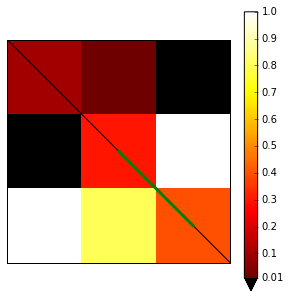

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
mpld3.enable_notebook()

# import matplotlib as mpl
# mpl.rc("savefig", dpi=600)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def my_heatmap_imshow(mat, fig, ax, threshold=1e-3, inverse=True, interactive=False):
    im = ax.imshow(mat, extent=(10, 20, 10, 20),
               origin='lower', zorder=1, interpolation='none')
    
    plugins.connect(fig, plugins.MousePosition(fontsize=14))

def my_heatmapMatshowSparse(mat, fig, ax, threshold=1e-3, inverse=True, interactive=False):
    
#     ax.spy(mat)
    from scipy.sparse import issparse
    if issparse(mat):
       im = ax.imshow(mat.todense(), extent=(10, 20, 10, 20),
               origin='lower', zorder=1, interpolation='none')
     
    else:
        im = ax.imshow(mat, extent=(10, 20, 10, 20),
               origin='lower', zorder=1, interpolation='none')
    
 
def my_heatmap(mat, fig, ax, title='',threshold=1e-2, inverse=True, interactive=False, gene_loc=None):
    
    seq_len = mat.shape[0]

    if interactive is True:
        print "Interactive, large memory consumer!"
        plugins.clear(ax)
        plugins.connect(fig, plugins.Reset(), plugins.BoxZoom(), plugins.Zoom())
        ax.plot(np.arange(seq_len+1,-1), np.arange(seq_len+1, -1),  c='black')
    else:
       ax.plot(np.arange(-1,seq_len+1), np.arange(-1,seq_len+1), c='black')
       if gene_loc is not None:
            print gene_loc
            assert len(gene_loc)==2
            ax.plot(np.arange(gene_loc[0],gene_loc[1]), np.arange(gene_loc[0],gene_loc[1]), c='green', linewidth=3)

    
    if inverse:
        cmap = plt.get_cmap('hot_r')
        my_hot_cmap = truncate_colormap(cmap, 0.1, 0.95) # Discards super white range of hit map
    else:
        cmap = plt.get_cmap('hot')
        my_hot_cmap = truncate_colormap(cmap, 0.15, 1.0) # Discards super white range of hit map
    
    
    
#     plugins.connect(fig, plugins.MousePosition(fontsize=14))
    
    heatmap = ax.matshow(mat, cmap=my_hot_cmap,vmin=threshold) #, interpolation='nearest')
    
    
#     y, x = np.mgrid[:mat.shape[0], :mat.shape[1]]
#     x,y = x.ravel(),y.ravel()
    
#     scatter = ax.scatter(x, y, c=mat, s=40, marker='s', edgecolor='none')
#     fig.plugins = [plugins.PointLabelTooltip(scatter, None)]
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    barticks =  [threshold] + [r/10.0 for r in range(1,11)]
    barlabels = [str(threshold)] + [str(r/10.0) for r in range(1,11)]
    cbar = fig.colorbar(heatmap, extend='min', ticks=barticks)
    cbar.ax.set_yticklabels(barlabels)
    if inverse: 
        cbar.cmap.set_under('white')
    else:
        cbar.cmap.set_under('black')

    #     plt.colorbar(heatmap)

    ax.set_title(title)
    
    ticks = np.arange(0,mat.shape[0],10)
    ax.set_xticks(ticks) 
    ax.set_yticks(ticks) 
    
    ax.set_xticks(ticks-0.5, minor=True) 
    ax.set_yticks(ticks-0.5, minor=True) 
#     ax.grid(True, which='minor',color='gray',linewidth=0.0001 )
    ax.grid(False, which='major')#,color='gray',linewidth=0.001 )
    #     ax.gca().patch.set_facecolor('0.8')
    ax.tick_params(length=0,
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
    
    ax.set_xlim((-0.5,seq_len-0.5))
#     ax.set_ylim((-0.5,seq_len-0.5))
    ax.set_ylim((seq_len-0.5, -.5))

    

def plot_heat_maps(mfe_probs, bp_probs_whole, filename='heatmap', what='all', inverse=False, interactive=False,gene_loc=[]):
    if what =='all':
        fig = plt.figure(figsize = (20,5))
        subplot_num = 140
    else:
        fig = plt.figure(figsize = (7,7))
        subplot_num = 110
        
    if what == 'basepairs' or what == 'all':
        my_heatmap(bp_probs_whole, fig, fig.add_subplot(subplot_num + 1), 'bp-probs'
                   ,inverse=inverse,interactive=interactive,gene_loc=gene_loc)
        
    if what == 'mfe-probs' or what == 'all':   
        my_heatmap(mfe_probs, fig, fig.add_subplot(subplot_num + 3), 'struct-probs', 
                   inverse=inverse, interactive=interactive,gene_loc=gene_loc)
    if what == 'all':   
        my_heatmap(bp_probs_whole*mfe_probs, fig, fig.add_subplot(subplot_num + 2), 'bp*struct',
                   inverse=inverse, interactive=interactive,gene_loc=gene_loc)
        my_heatmap(np.sqrt(bp_probs_whole*mfe_probs), fig, fig.add_subplot(subplot_num + 4), 'sqrt(bp*struct)',
                   inverse=inverse, interactive=interactive, gene_loc=gene_loc)

    #     fig.savefig(filename+'.png', dpi=800)
    fig.savefig(filename+'.pdf', dpi=100)
    fig.savefig(filename+'.svg', dpi=100, format="svg")
#     return fig

def my_heatmaps(rna_seq, context_all, context_len, insert_pos=None, filename='heatmap', what='all', 
                inverse=True,interactive=False):
    
    context_selection = context_all[0:context_len]
    if insert_pos is None:
        insert_pos = len(context_selection)/2
    whole_seq_context = context_selection[:insert_pos] +  rna_seq + context_selection[insert_pos:]
    print len(rna_seq), len(context_selection), insert_pos
    plot_heat_maps(get_mfe_probs(whole_seq_context), getBPPM(whole_seq_context), filename, what, 
                   inverse=inverse, interactive=interactive, gene_loc=[insert_pos,insert_pos+len(rna_seq)])

%matplotlib inline
mpld3.enable_notebook()

mynp = np.array([[0.1,0.01,0.001],[0.00,0.3,1.0],[1.0,0.8,.4]])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
# my_heatmap(mynp, fig, ax)
my_heatmap(mynp, fig, ax, inverse=False, interactive=False, gene_loc=[1,3])


72 150 100
720
[100, 172]
[100, 172]
[100, 172]
[100, 172]


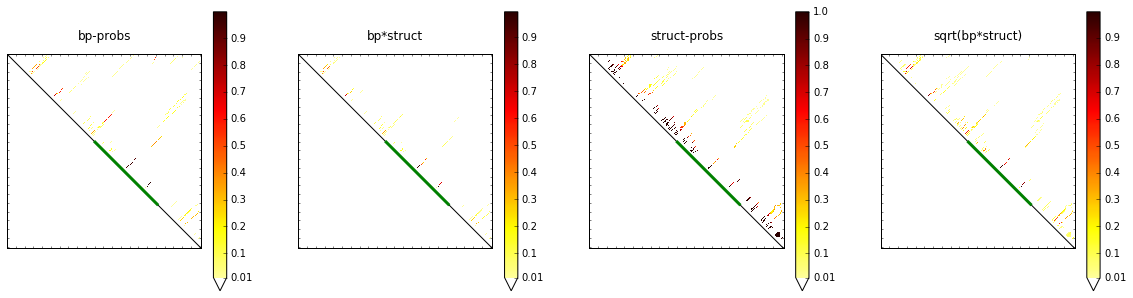

In [48]:
# RNA.get_pr(l_pos+1, r_pos+1)
context_histone_shuffled = dinuclShuffle(context_histone.upper())
context_trna2_shuffled = dinuclShuffle(context_trna2.upper())

# my_heatmaps(histone, context_histone_shuffled,context_len = 150, filename='histone-shuffled-150', 
#            what='all')
my_heatmaps(trna2, context_trna2_shuffled, insert_pos=100, context_len=150, filename='trna-shuffled-150')
# my_heatmaps(trna2, context_trna2_shuffled, context_len=0, filename='trna-shuffled-0')


In [ ]:
# tran2 >X70810.2_30807-30878
trna2="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
context_trna2 = "uaugauauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaaauuguaaa\
uccguauuauuuauaaauugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaauaaauauuuuguauaaaaaugugugauuauuu\
aaaagauuucuuccauuucaugacuuuuaauuuuaaaaaaaaauuucaaguauguggccauguauccguauuuggagacaagaagcaagaaaagguu\
uucuuuauaaaaaaguuuagguguuu\
uuauuuuagguaacuuuuuaagcguguuucaccggugcauucaguuuuuuuaguaaugcauaugucauugcaauuuuagcauuauguaaucuuaaa\
agcuuuugucauauuucucaacugcuaugauauauugauaggaguccuucucaauggaugcgggagaauaaauauauuguucacgguagucuaaggc\
ucauugcccccuuuuuaaagucuuagcuuucaucaugcccaggauaaaauaaucaguguugcaauaguucaaauaagcuuaauucaaaguuuauuuuagaggaucgg"
random.seed(1)
np.random.seed(10)

context_trna2_shuffled = dinuclShuffle(context_trna2.upper())
sample_trna2 = context_trna2_shuffled[0:100] + trna2 + context_trna2_shuffled[100:200]
context_trna2_shuffled = dinuclShuffle(context_trna2.upper())
sample_trna2_assymetric = context_trna2_shuffled[0:120] + trna2 + context_trna2_shuffled[120:200]

print ">sample_trna2\n", sample_trna2

In [ ]:
context_histone_shuffled = dinuclShuffle(context_histone.upper())
sample_histone = context_histone_shuffled[0:100] + histone + context_histone_shuffled[100:200]
print ">sample_histone\n", sample_histone

In [ ]:
import pickle
with open('targets-pankoff/'+ 'sample_trna_foldscore_dict' + '.pkl', 'rb') as f:
    sample_trna2_loaded_dict = pickle.load(f)
import numpy as np
def parse_dp_ps_mine(ps_file, sparse=False):
    '''Extracts base pair probabliies from vienna ps file
    returns: Numpy 2d array of form arr[i,j]=p(i,j) '''
   
    # Extract sequence from ps file
    myseq = ""
    read_seq = False
    with open(ps_file) as in_ps:
        for line in in_ps:
            if "/sequence" in line:
                read_seq = True
            elif read_seq and ") } def" in line:
                read_seq = False
            elif read_seq:
                myseq += line.rstrip().rstrip("\\")
    #     print ps_file.rstrip("_dp.ps") , myseq
              
    import re
    
    # e.g. 52 56 0.020043762 ubox
    ureg = re.compile(r'^(\d+)\s+(\d+)\s+(\d+\.\d+)\s+[ul]box\s*')
    
    # e.g. 1 70 0.9500000 lbox
    #     lreg = re.compile(r'^(\d+)\s+(\d+)\s+(\d+\.\d+)\s+lbox\s*')
    
    bp_prob_dict = dict()
    mfe_struct_dict = dict()
    from scipy.sparse import csr_matrix
    if sparse:
        bp_prob_mat = csr_matrix((len(myseq), len(myseq)))

    else:
        bp_prob_mat = np.zeros((len(myseq), len(myseq)))
 

    with open(ps_file) as in_ps:
        for line in in_ps:
            if "ubox" in line or "lbox" in line:
                um = ureg.match(line)
                if um:
                    i, j, sqrp = um.groups()

                    #                     print i, j, sqrp
                    
                    # keys are pair of indexes as smaller:larger
                    key = ":".join([i,j])
                    if "ubox" in line: # upper triangle of probs
                        assert (key not in bp_prob_dict)
                        bpprob = float(sqrp)*float(sqrp)
                        bp_prob_dict[key] = bpprob

                        i,j = int(i), int(j)
                        bp_prob_mat[i-1,j-1] = bpprob
                    else: # lower part mfe struct
                        i,j = int(i), int(j)
                        assert (key not in mfe_struct_dict)
                        mfe_struct_dict[key] = 1
                    
    return bp_prob_mat, mfe_struct_dict


%matplotlib inline
def bpp_dict_to_np_array(d, seq):
    np_arr = np.zeros((len(seq), len(seq)))
    for pair in d:
        i, j = pair.split(':')
        np_arr[i,j] = d[pair]
    return np_arr

def plot_dp_ps(dp):
    from os.path import basename
#     from pankoff_lib import parse_dp_ps
    np_arr, mfe_dict = parse_dp_ps_mine(dp, True)
    print np_arr
    return plot_heat_maps(None, np_arr, basename(dp), 'basepairs', inverse=True, interactive=False)
mpld3.disable_notebook()

plot_dp_ps('./targets-pankoff/cluster_10546_dp.ps')

In [ ]:
sample_np = bpp_dict_to_np_array(sample_trna2_loaded_dict, sample_trna2) 
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
my_heatmap(sample_np, fig, ax)
fig.savefig('foldscore_sample_trna2.pdf')

In [ ]:
# plot_heat_maps(get_mfe_probs(sample_trna2), getBPPM(sample_trna2), 'sample_trna2', 'all')
plot_heat_maps(None, getBPPM(sample_trna2), 'sample_trna2_bp_probs', 'basepairs', inverse=True, interactive=True)
# plot_heat_maps(None, getBPPM(sample_trna2), 'sample_trna2_bp_probs_inverse', 'basepairs', inverse=False)
# plot_heat_maps(None, getBPPM(sample_trna2_assymetric), 'sample_trna2_bp_probs_asymmetric', 'basepairs', inverse=True)
# plot_heat_maps(None, getBPPM(sample_trna2_assymetric), 'sample_trna2_bp_probs_inverse_asymmetric', 'basepairs', inverse=False)
# plot_heat_maps(None, getBPPM(trna2), 'X70810.2_heatmap', 'basepairs', inverse=True, interactive=True)

In [ ]:
struct = ""
t = RNA.fold_compound("GCCGAAAGGC")#, struct)
print t.mfe()
t.__class__
# RNA.fold_compound.
# RNA.fold_compound.mfe(t)
# RNA.fold_compound.type()
# print t

import RNA
print RNA.__path__
structure = ""
# print RNA.pf_fold("AAGGGAAACCCAGGCGGCGC", structure)
# VRNA_VC_TYPE_SINGLE
RNA.Lfold("AAGGGAAACCCAGGCGGCGC")